Celem zadania było przebadanie dwóch kryteriów uczenia modelu liniowego MSE oraz MAE wraz z różnymi formamy regularyzacji modeli: l1 oraz l2. 
Zadanie wymagało zapoznania się z liniowymi modelami regresyjnymi, wykonania ekperymentu, a na koniec wyciągnięcia wniosków.

Importy:

In [1]:
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, HuberRegressor, Lasso
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import time
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

Klasa pomocnicza, której zadaniem jest ułatwienie pomiaru czasu dla danego fragmentu kodu

Metody:
* `measure` - mierzy czas wykonania danej funkcji. Zwraca czas wykonywania funkcji oraz wynik, który funkcja zwróciła.

In [2]:
class StopWatch:
    def measure(self, callback: callable, params: list = []) -> Tuple:
        t1 = time.time()
        results = callback(*params)
        t2 = time.time()
        t = t2 - t1

        return t, results

Poniżej klasa odpowiedzialna za wykonanie eksperymentów. 

Opis atrybutów:
* `max_iter` - maksymalna liczba iteracji dla regresorów
* `polynomial_degrees` - stopnie wielomianowe do wykorzystania w `PolynomialFeatures`
* `results` - atrybut, w którym będą przechowywane resultaty eksperymentów
* `__stop_watch` - instancja klasy `StopWatch` opisanej powyżej

Metody:
* `experiment` - główna metoda odpowiedzialna za wykonanie eksperymentu dla zadanego rodzaju zbioru danych (liniowy lub nieliniowy). Generuje ona dane o zadanym rozmiarze, dokładając sztuczny szum w zależności od parametru `strong_noise`.
* `experiment_for_polynomial_degree` - metoda pomocnicza, która wykonuje eksperyment dla regresorów wybranych w zależności od typu zbioru danych oraz generuje wykres.
* `experiment_for_regressor` - metoda pomocnicza, która deleguje wykonanie odpowiedniego eksperymentu dla regresora z zależności od typu zbioru danych
* `experiment_linear_for_regressor` - metoda wykonująca uczenie, predykcję oraz wyliczjąca miary MSE i MAE dla podanego regresora dla liniowego zbioru danych
* `experiment_nonlinear_for_regressor` - metoda wykonująca uczenie, predykcję oraz wyliczjąca miary MSE i MAE dla podanego regresora dla nieliniowego zbioru danych
* `generate_dataset` - metoda delegująca generowanie odpowiedniego zbioru danych dla podanego typu zbioru danych
* `generate_linear_dataset` - metoda generująca dane dla modelu liniowego z szumem gaussowskim
* `generate_non_linear_dataset` - metoda generująca dane dla modelu nieliniowego z szumem gaussowskim
* `generate_gauss_noise_for_data` - statyczna metoda generująca szum gaussowski dla podanych danych, bazująca na rozmiarze przekazanych danych
* `add_strong_noise` - statyczna metoda generująca sztuczny szum dla danych losowo w ilości 5-10% przekazanch danych
* `apply_polynomial_features` - metoda statyczna dodająca jako warstwę pośrednią do danych cechy wielomianowe o zadanym stopniu
* `get_regressors` - metoda pomocnicza delegująca zwrócenie odpowiednich regresorów w zależności od rodzaju modelu danych
* `get_regressors_for_linear_experiment` - metoda generująca modele regresji dla liniowego modelu danych
* `get_regressors_for_non_linear_experiment` - metoda generująca modele regresji dla nieliniowego modelu danych

In [3]:
class RegressionClassifierTest:
    def __init__(self, max_iter: int = 50000):
        self.max_iter: int = max_iter
        self.polynomial_degrees = [3, 5, 10, 15, 30, 60]

        self.results = None
        self.__stop_watch = StopWatch()

    def experiment(self, dataset_type: str = 'linear', strong_noise: bool = False, dataset_size: int = 100) -> None:
        self.results = pd.DataFrame()

        x, y = self.generate_dataset(dataset_size, dataset_type)
        y_noised = self.add_strong_noise(y, 30) if strong_noise else y

        data = {'x': x, 'y': y, 'y_noised': y_noised, 'strong_noise': strong_noise}

        for polynomial_degree in self.polynomial_degrees if dataset_type != 'linear' else [-1]:
            if dataset_type != 'linear':
                x_train, x_test = self.apply_polynomial_features(x, polynomial_degree)
                data = {**data, 'x_train': x_train, 'x_test': x_test}

            self.experiment_for_polynomial_degree(polynomial_degree, data, dataset_type)

    def experiment_for_polynomial_degree(self, deg: int, data: dict, dataset_type: str = 'linear'):
        regressors = self.get_regressors(dataset_type)
        plot_title = f'{dataset_type.capitalize()} {"with" if data["strong_noise"] else "without"} strong artificial noise'
        plot_title += f', polynomial degree = {deg}' if deg != -1 else ''

        plt.figure(figsize=(20, 10))
        plt.title(plot_title)

        plt.scatter(data['x'], data['y'], label='Train samples')
        plt.scatter(data['x'], data['y_noised'], label='Test samples', alpha=0.6)

        for regressor in regressors:
            regressor_experiment_data = (regressor, data, True)
            results = self.experiment_for_regressor(regressor_experiment_data, dataset_type)

            if dataset_type != 'linear':
                results['polynomial degree'] = deg

            self.results = pd.concat([self.results, results.to_frame().T], ignore_index=True)

        plt.legend()
        plt.show()

    def experiment_for_regressor(self, params: tuple, dataset_type: str = 'linear'):
        return self.experiment_linear_for_regressor(*params) if dataset_type == 'linear' else self.experiment_nonlinear_for_regressor(*params)

    def experiment_linear_for_regressor(self, regressor: RegressorMixin, data: dict, plot: bool = True) -> pd.Series:
        fit_time, _ = self.__stop_watch.measure(regressor.fit, [data['x'], data['y']])
        predict_time, y_predicted = self.__stop_watch.measure(regressor.predict, [data['x']])

        mse = mean_squared_error(data['y_noised'], y_predicted)
        mae = mean_absolute_error(data['y_noised'], y_predicted)

        regressor_name = regressor.__class__.__name__
        label = regressor_name + f' - {regressor.penalty}' if regressor_name == 'SGDRegressor' else regressor_name

        if plot:
            plt.plot(data['x'], y_predicted, label=label)

        return pd.Series({
            'regressor': regressor_name,
            'fit time': fit_time,
            'predict time': predict_time,
            'mse': mse,
            'mae': mae,
        })

    def experiment_nonlinear_for_regressor(self, regressor: RegressorMixin, data: dict, plot: bool = True) -> pd.Series:
        fit_time, _ = self.__stop_watch.measure(regressor.fit, [data['x_train'], data['y']])
        predict_time, y_predicted = self.__stop_watch.measure(regressor.predict, [data['x_test']])

        mse = mean_squared_error(data['y_noised'], y_predicted)
        mae = mean_absolute_error(data['y_noised'], y_predicted)

        regressor_name = regressor.__class__.__name__
        label = regressor_name + f' - {regressor.penalty}' if regressor_name == 'SGDRegressor' else regressor_name

        if plot:
            plt.plot(data['x'], y_predicted, label=label)

        return pd.Series({
            'regressor': regressor_name,
            'fit time': fit_time,
            'predict time': predict_time,
            'mse': mse,
            'mae': mae,
        })

    def generate_dataset(self, size: int, dataset_type: str = 'linear'):
        return self.generate_linear_dataset(size) if dataset_type == 'linear' else self.generate_non_linear_dataset(size)

    def generate_linear_dataset(self, size: int = 100) -> Tuple:
        x = np.sort(np.random.uniform(-2, 2, size)).reshape(-1, 1)
        y = 2 * x + 4
        y += self.generate_gauss_noise_for_data(y)

        return x, y

    def generate_non_linear_dataset(self, size: int = 100) -> Tuple:
        x = np.sort(np.random.uniform(-2, 2, size)).reshape(-1, 1)
        y = 2 * x ** 3 + 3 * x + 1
        y += self.generate_gauss_noise_for_data(y)

        return x, y

    @staticmethod
    def generate_gauss_noise_for_data(data: np.array) -> np.array:
        return np.random.normal(0, np.std(data) / 10, data.shape)

    @staticmethod
    def add_strong_noise(data: np.array, modifier: float = 5) -> np.array:
        data = np.copy(data)
        min_val = np.min(data)
        max_val = np.max(data)

        sample_indexes = np.random.randint(data.size, size=np.random.randint(0.05 * data.size, 0.11 * data.size))
        for sample_index in sample_indexes:
            data[sample_index] += np.random.randint(min_val - modifier, max_val + modifier)

        return data

    @staticmethod
    def apply_polynomial_features(data: np.array, deg: int) -> Tuple:
        scaler = StandardScaler()
        polynomial_features = PolynomialFeatures(deg)

        data_train = scaler.fit_transform(polynomial_features.fit_transform(data))
        data_test = scaler.fit_transform(polynomial_features.fit_transform(data))

        return data_train, data_test

    def get_regressors(self, dataset_type: str = 'linear'):
        return self.get_regressors_for_linear_experiment() if dataset_type == 'linear' else self.get_regressors_for_non_linear_experiment()

    def get_regressors_for_linear_experiment(self) -> list:
        return [
            LinearRegression(),
            HuberRegressor(),
            Ridge(),
            SGDRegressor(loss='huber', penalty='l1', max_iter=self.max_iter, tol=1e-6),
            SGDRegressor(loss='huber', penalty='l2', max_iter=self.max_iter, tol=1e-6),
            Lasso(alpha=0.01),
        ]

    def get_regressors_for_non_linear_experiment(self) -> list:
        return [
            LinearRegression(),
            HuberRegressor(epsilon=1, max_iter=self.max_iter),
            Ridge(),
            SGDRegressor(loss='huber', penalty='l1', max_iter=self.max_iter, tol=1e-6),
            SGDRegressor(loss='huber', penalty='l2', max_iter=self.max_iter, tol=1e-6),
            Lasso(alpha=0.01),
            MLPRegressor(),
        ]

Ignorowanie wybranych błędów oraz utworzenie klasy testującej:

In [4]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

regressionClassifierTest = RegressionClassifierTest()

Wykonanie eksperymentu dla liniowego modelu danych bez sztucznego szumu:

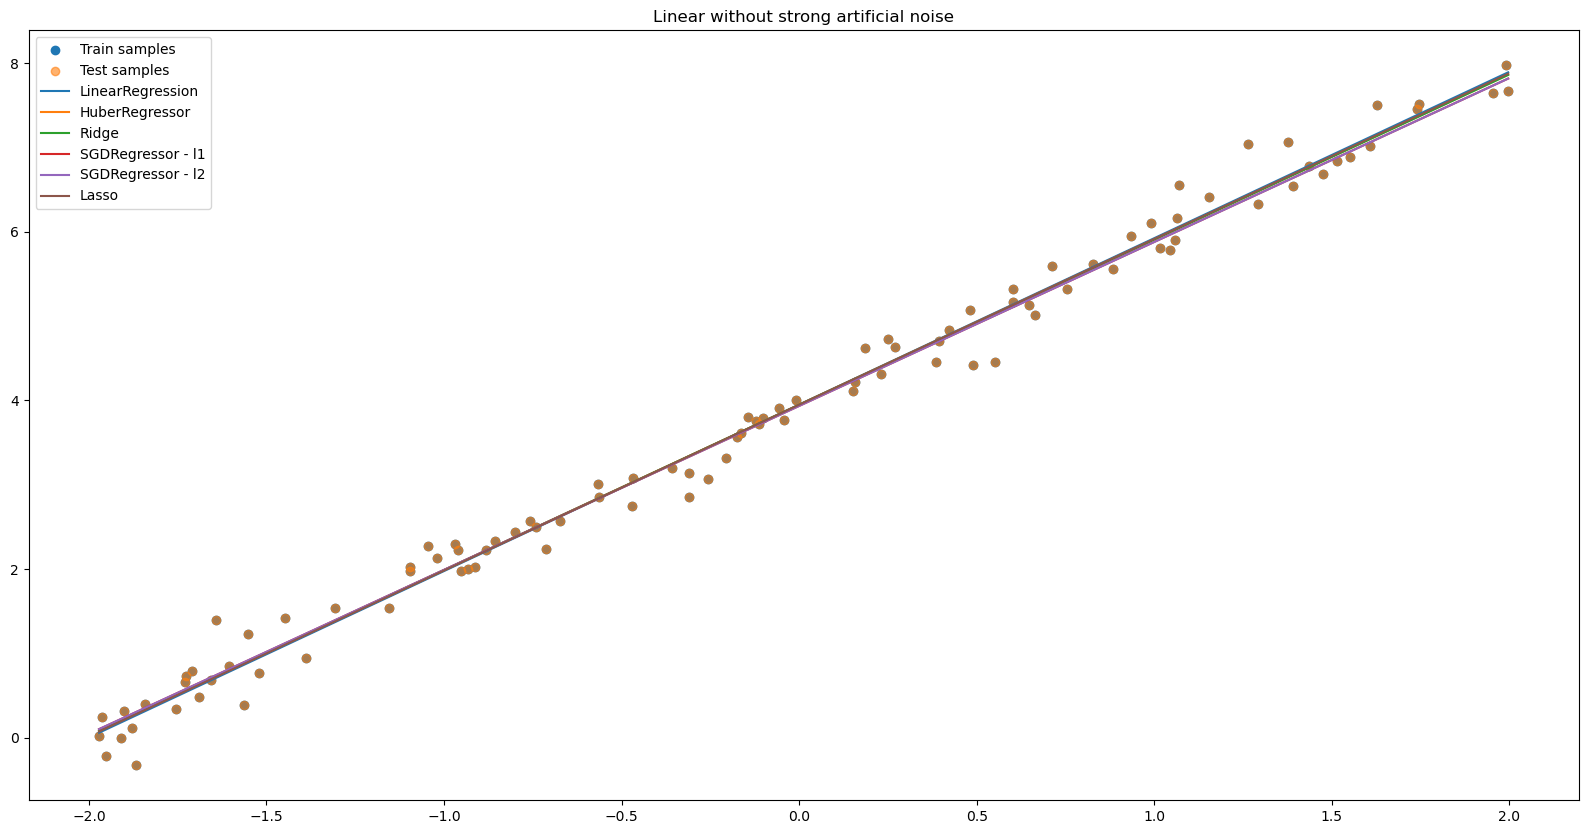

|    | regressor        |   fit time |   predict time |       mse |      mae |
|---:|:-----------------|-----------:|---------------:|----------:|---------:|
|  0 | LinearRegression | 0          |              0 | 0.0530276 | 0.179857 |
|  1 | HuberRegressor   | 0.00300074 |              0 | 0.0532091 | 0.179086 |
|  2 | Ridge            | 0.00100183 |              0 | 0.0533179 | 0.178979 |
|  3 | SGDRegressor     | 0.00400233 |              0 | 0.0542818 | 0.178869 |
|  4 | SGDRegressor     | 0.0050056  |              0 | 0.0542944 | 0.178863 |
|  5 | Lasso            | 0          |              0 | 0.0531032 | 0.179264 |


In [9]:
with warnings.catch_warnings() and pd.option_context('display.max_rows', None, 'display.max_columns', None):
    regressionClassifierTest.experiment(dataset_type='linear', strong_noise=False)
    aggregated = regressionClassifierTest.results.to_markdown()
    print(aggregated)

Wykonanie eksperymentu dla liniowego modelu danych ze sztucznym szumem:

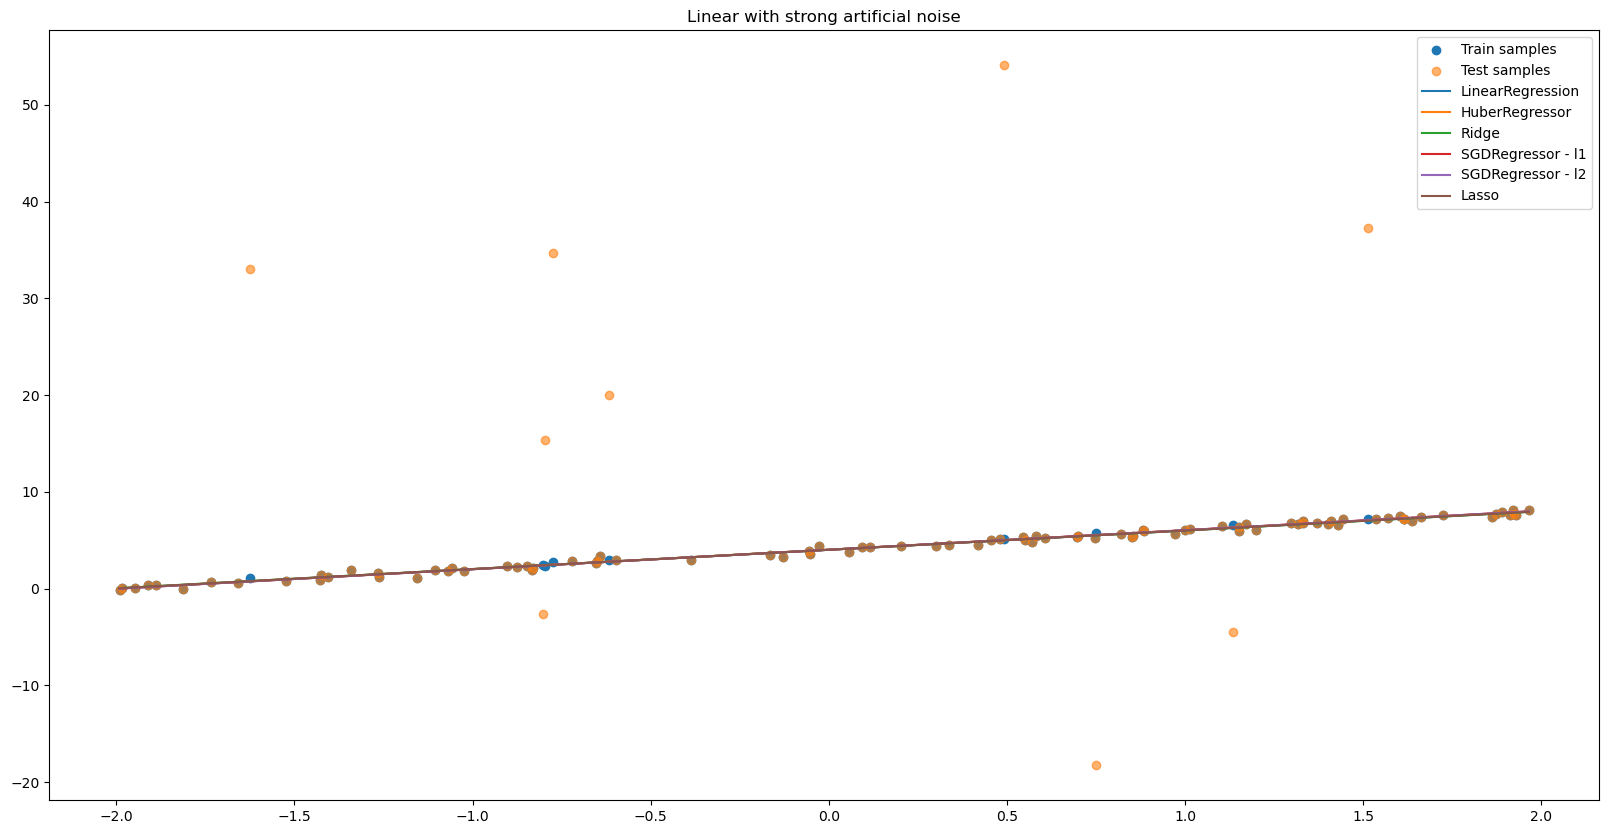

|    | regressor        |   fit time |   predict time |     mse |     mae |
|---:|:-----------------|-----------:|---------------:|--------:|--------:|
|  0 | LinearRegression | 0          |              0 | 65.8057 | 2.31436 |
|  1 | HuberRegressor   | 0.00299382 |              0 | 65.7763 | 2.31416 |
|  2 | Ridge            | 0.00100803 |              0 | 65.7825 | 2.31512 |
|  3 | SGDRegressor     | 0.00400019 |              0 | 65.7964 | 2.31458 |
|  4 | SGDRegressor     | 0.00400519 |              0 | 65.796  | 2.31456 |
|  5 | Lasso            | 0          |              0 | 65.794  | 2.31455 |


In [10]:
with warnings.catch_warnings() and pd.option_context('display.max_rows', None, 'display.max_columns', None):
    regressionClassifierTest.experiment(dataset_type='linear', strong_noise=True)
    aggregated = regressionClassifierTest.results.to_markdown()
    print(aggregated)

Wykonanie eksperymentu dla nieliniowego modelu danych bez sztucznego szumu:

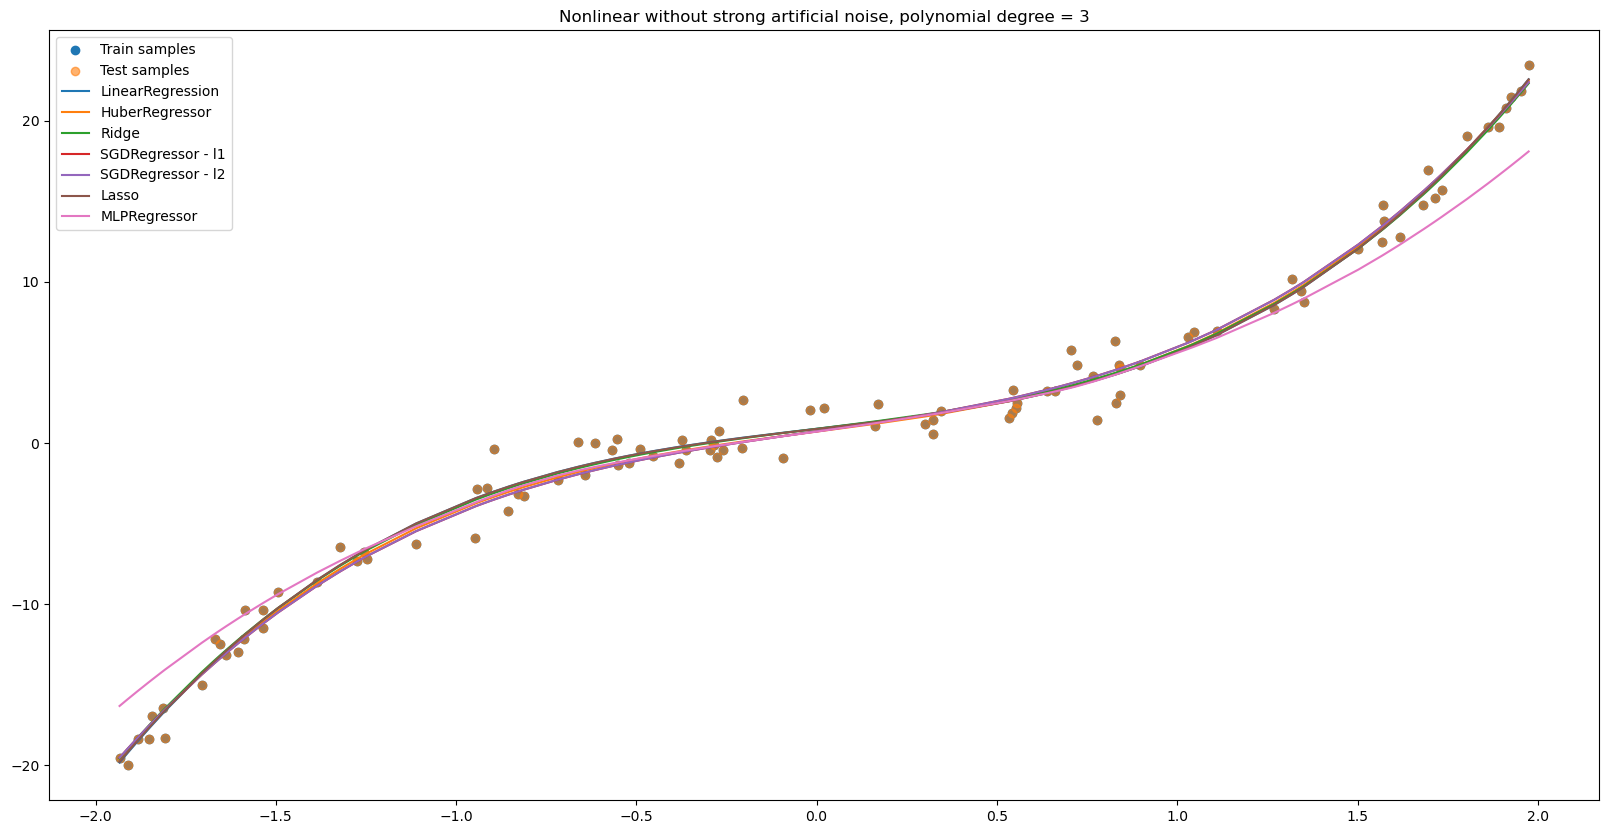

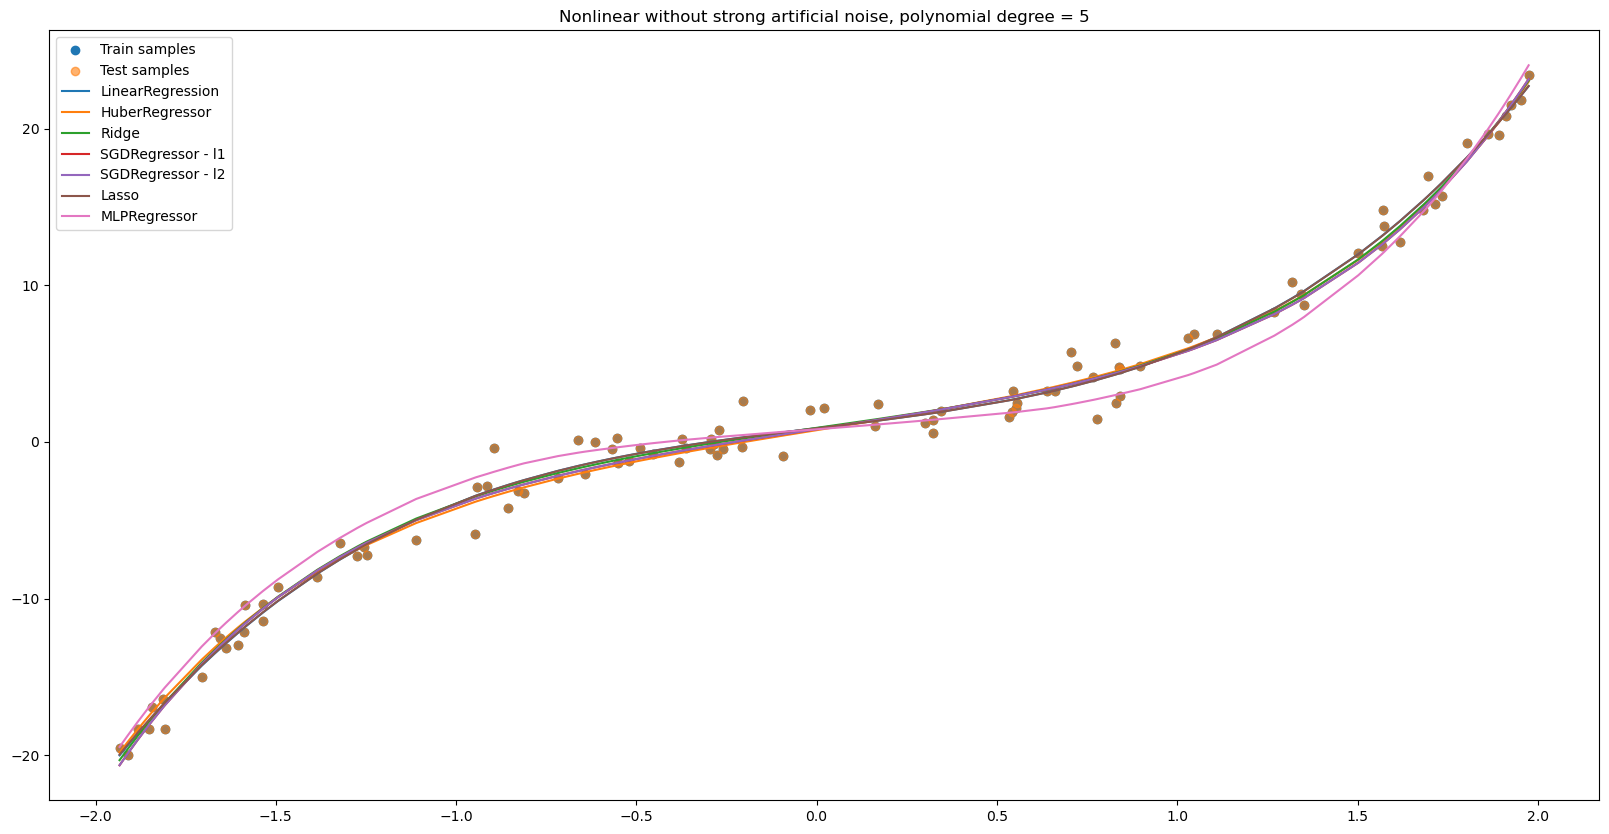

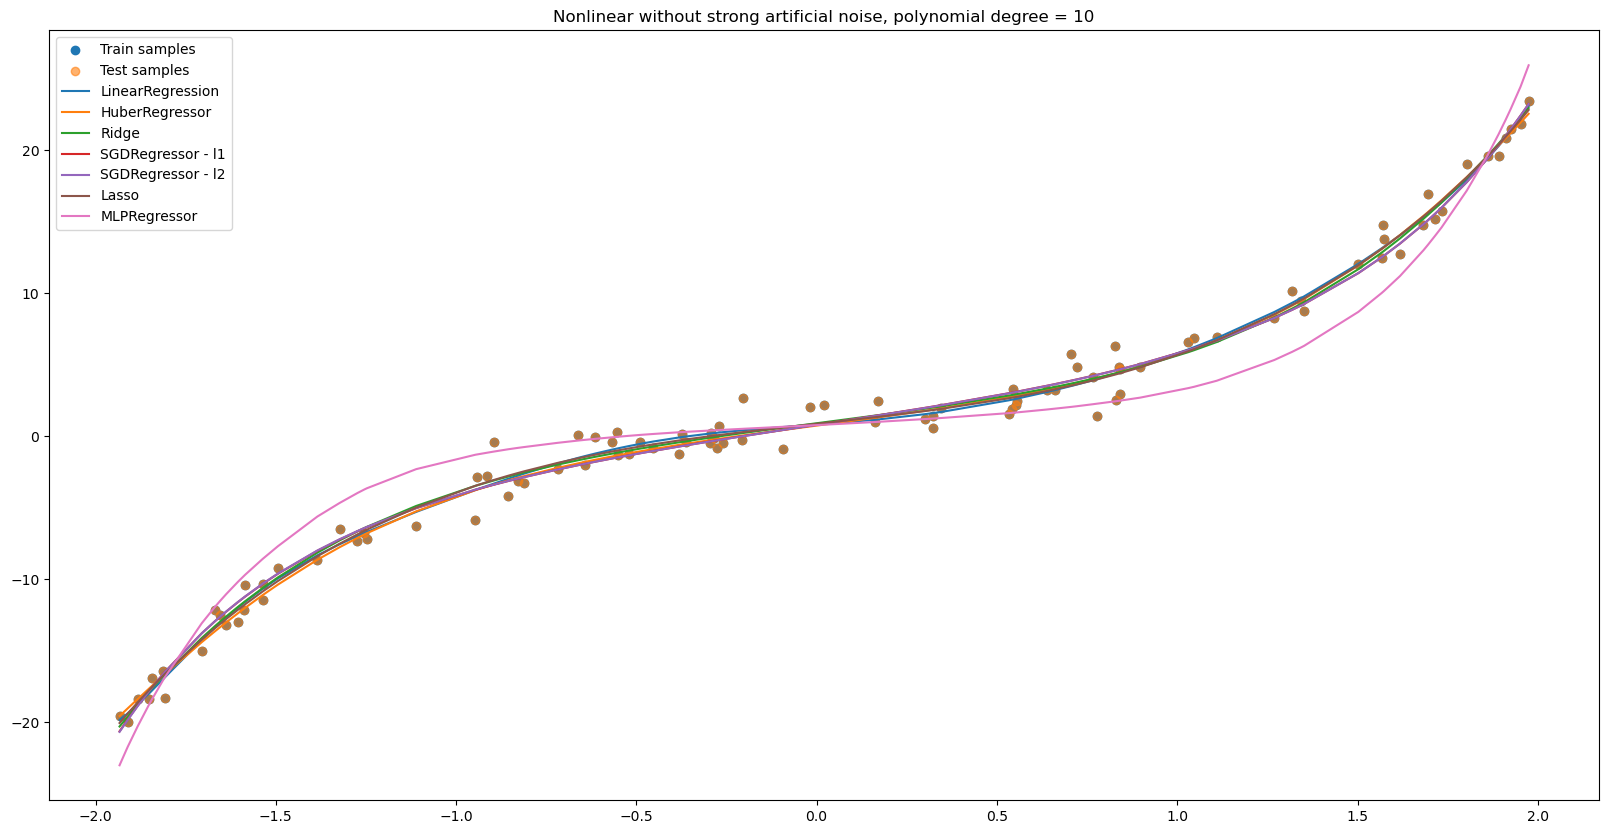

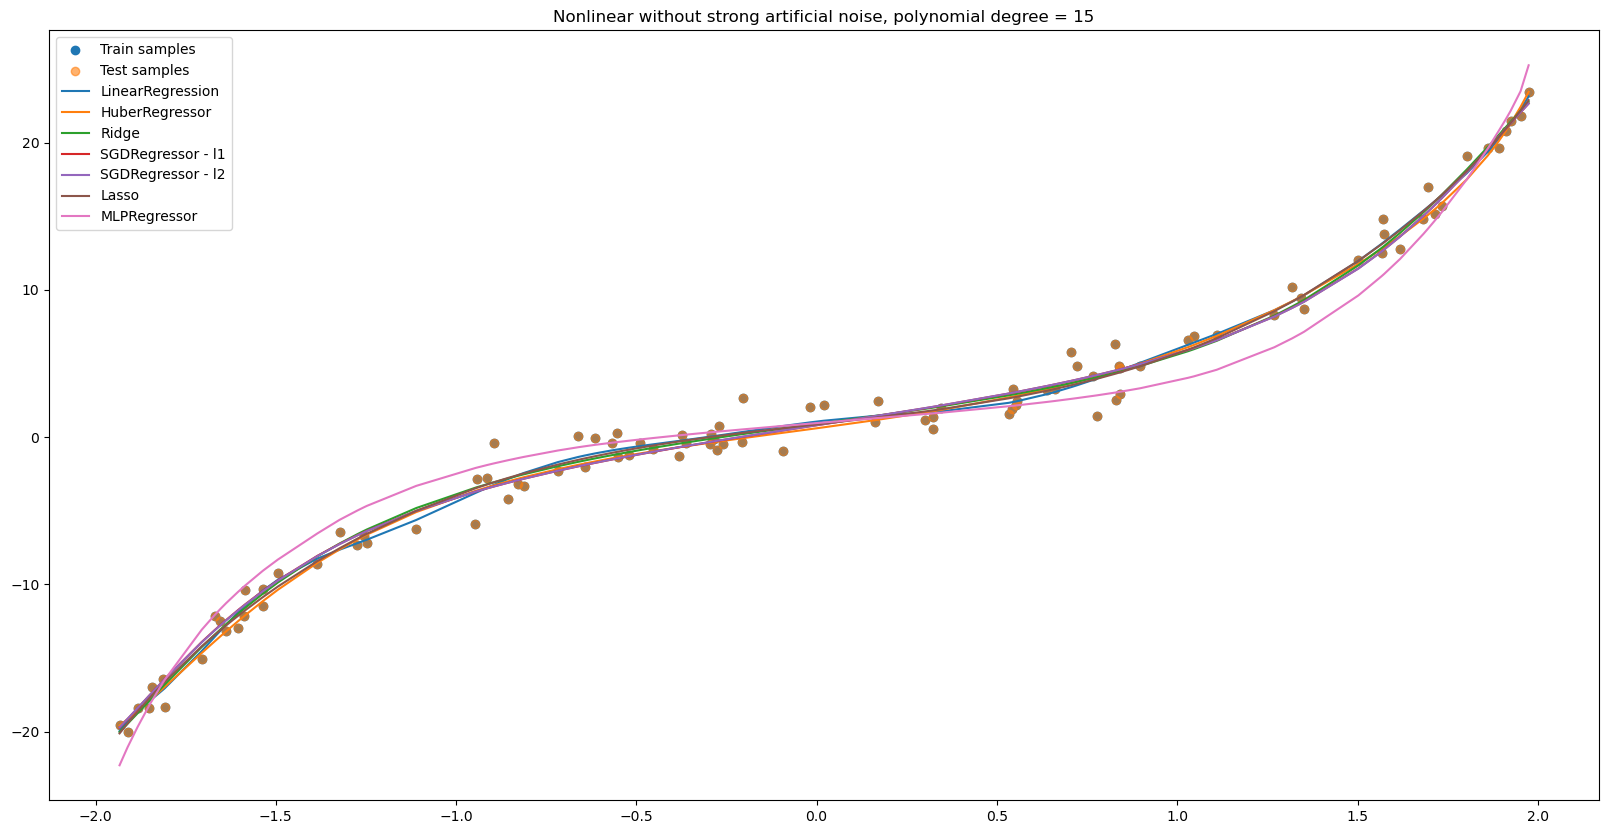

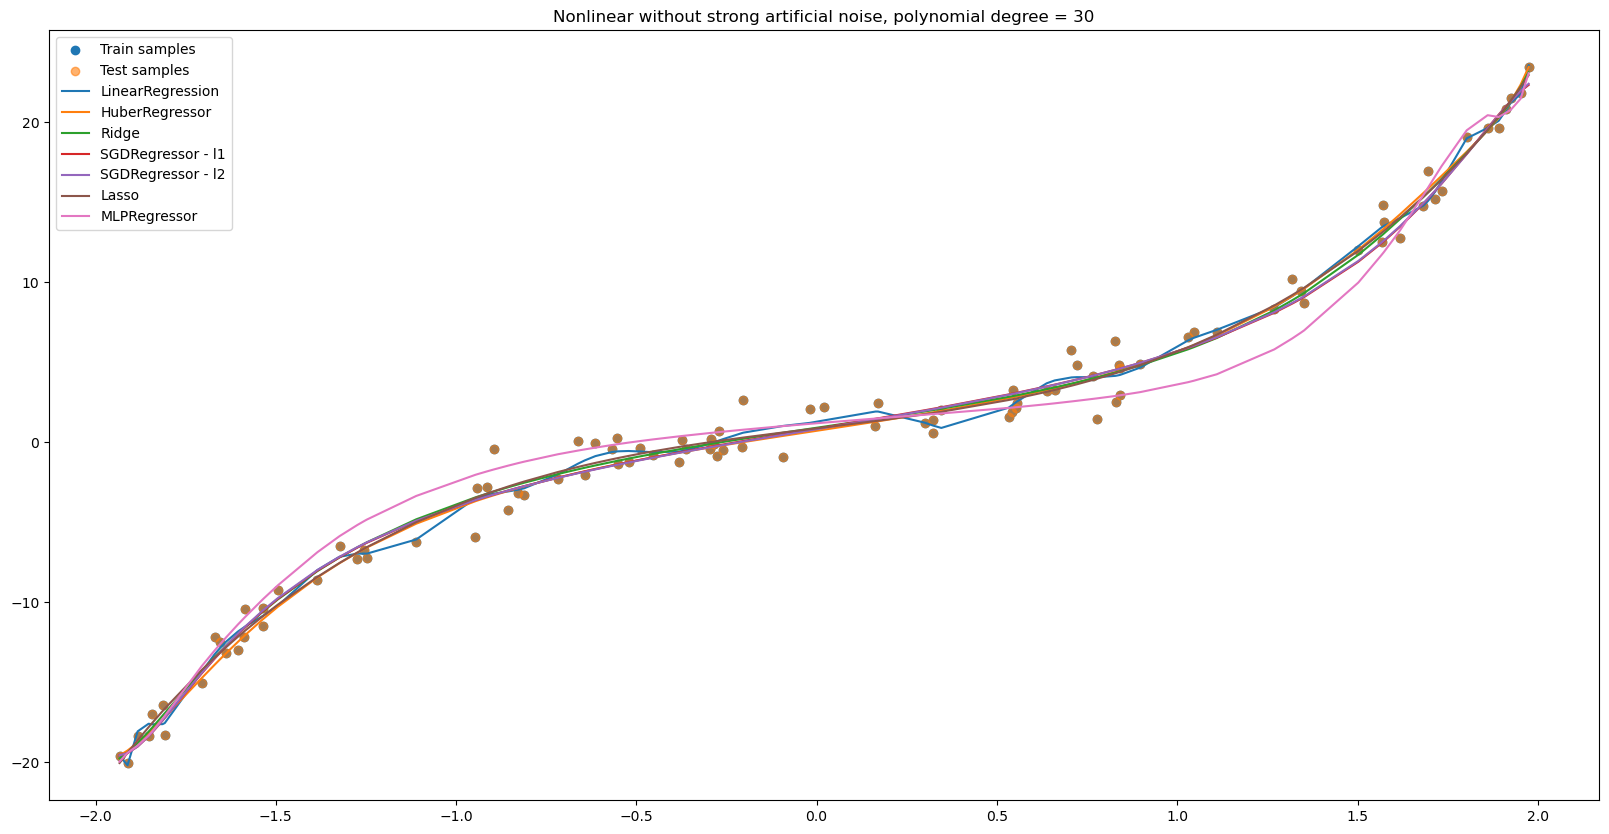

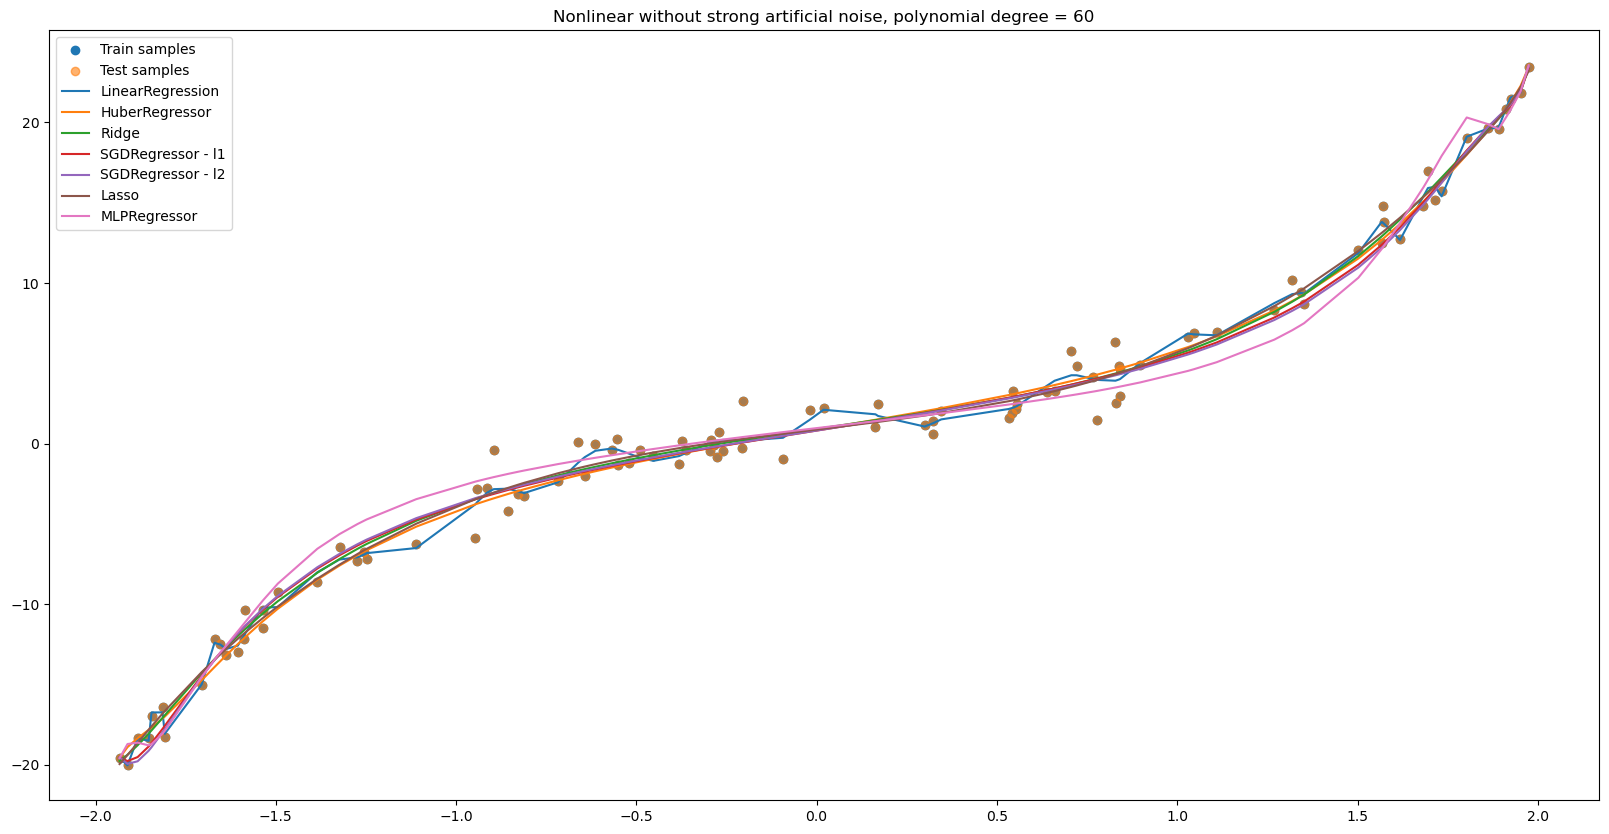

                                    fit time       mae       mse  predict time
polynomial degree regressor                                                   
3                 HuberRegressor    0.008031  0.761158  0.991024      0.000000
                  Lasso             0.000000  0.778371  0.957002      0.000000
                  LinearRegression  0.001002  0.778631  0.956794      0.000000
                  MLPRegressor      0.088534  1.333136  3.245729      0.001000
                  Ridge             0.000000  0.775529  0.967146      0.000000
                  SGDRegressor      0.030481  0.771657  1.041175      0.000000
5                 HuberRegressor    0.008002  0.782144  1.047973      0.000000
                  Lasso             0.000000  0.777506  0.952773      0.000000
                  LinearRegression  0.000000  0.777911  0.952549      0.000000
                  MLPRegressor      0.096029  1.145292  2.008770      0.000000
                  Ridge             0.001005  0.7877

In [7]:
with warnings.catch_warnings() and pd.option_context('display.max_rows', None, 'display.max_columns', None):
    regressionClassifierTest.experiment(dataset_type='nonlinear', strong_noise=False)
    aggregated = pd.pivot_table(regressionClassifierTest.results, values=['fit time', 'predict time', 'mse', 'mae'], index=['polynomial degree', 'regressor'], aggfunc=np.mean)
    print(aggregated)

Wykonanie eksperymentu dla nieliniowego modelu danych ze sztucznym szumem:

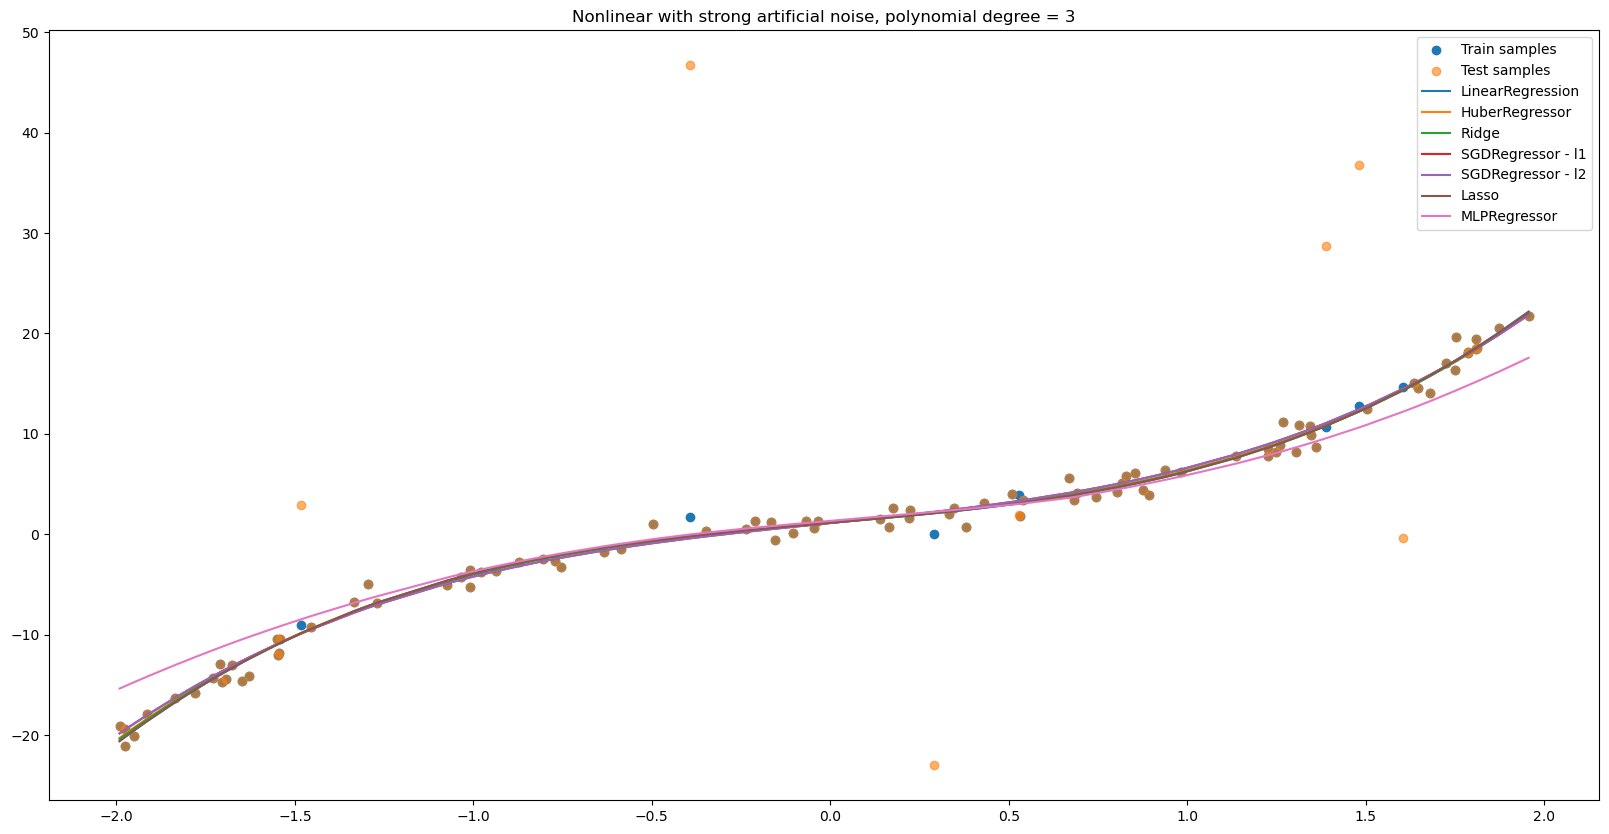

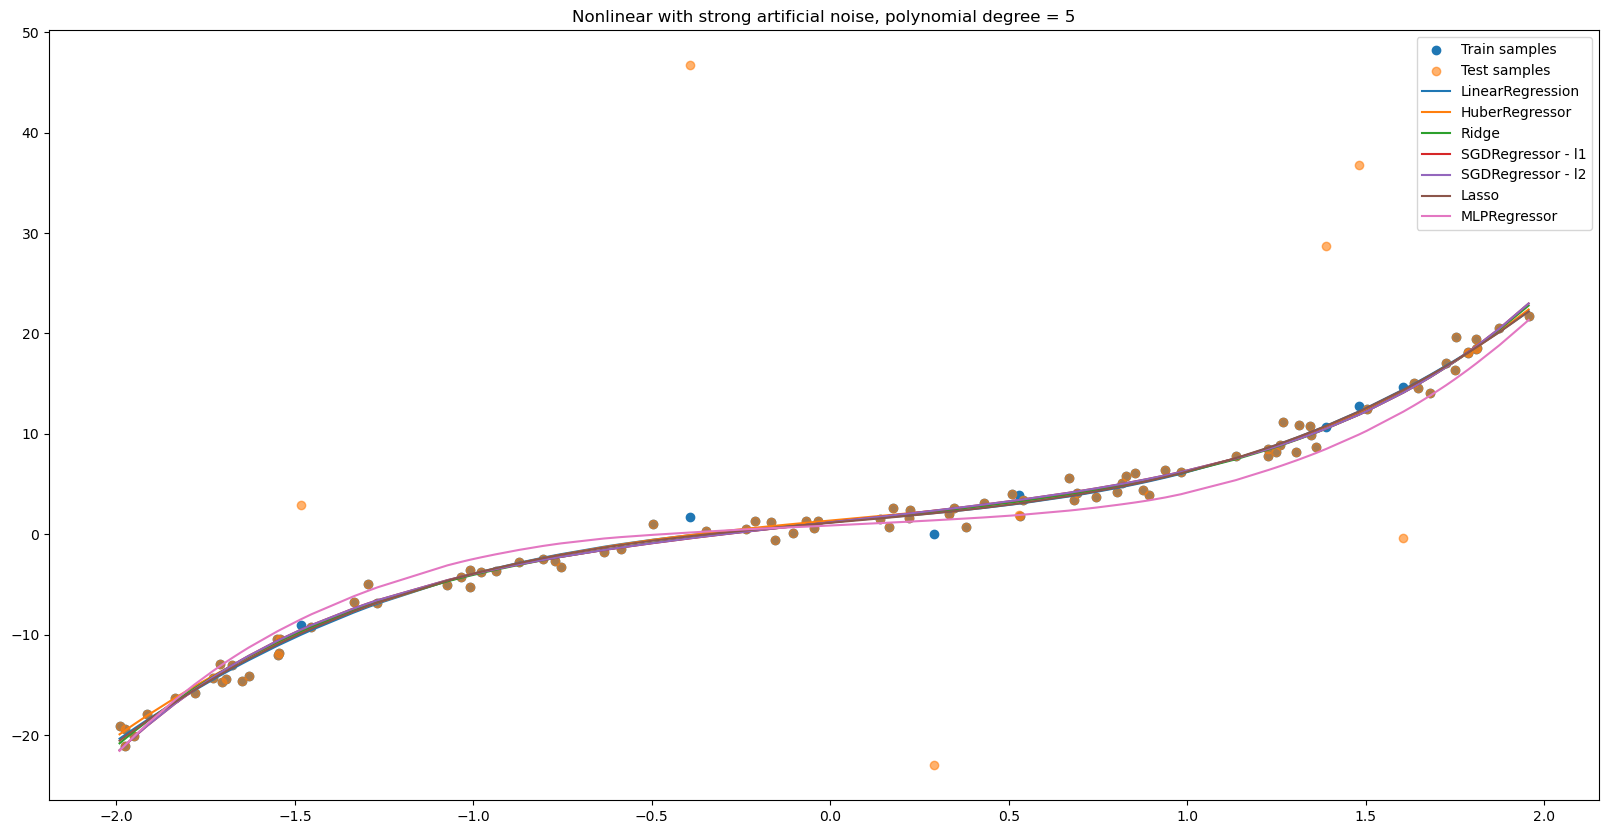

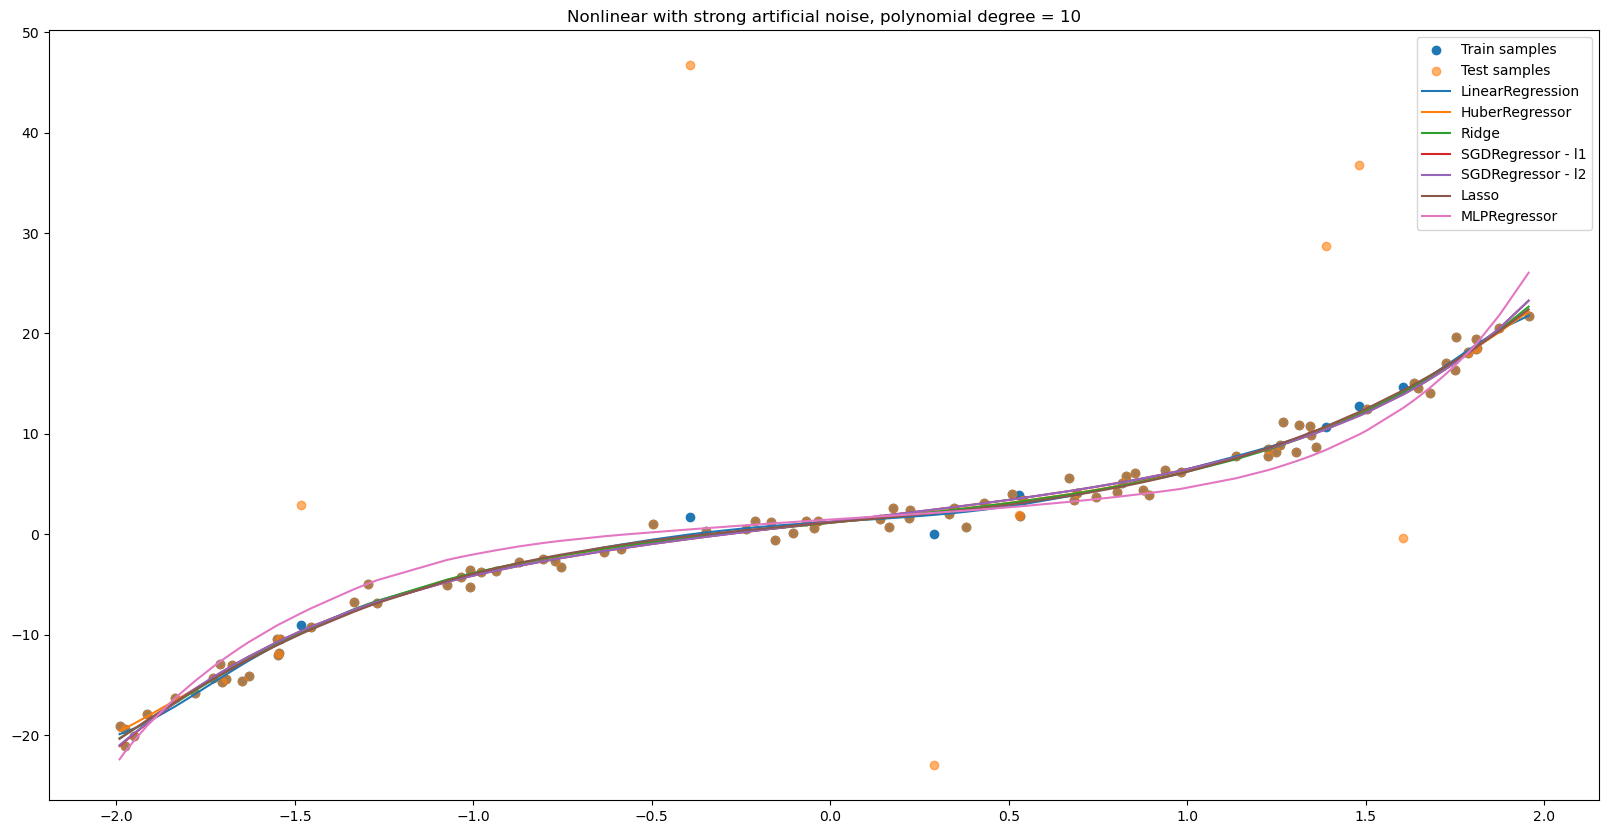

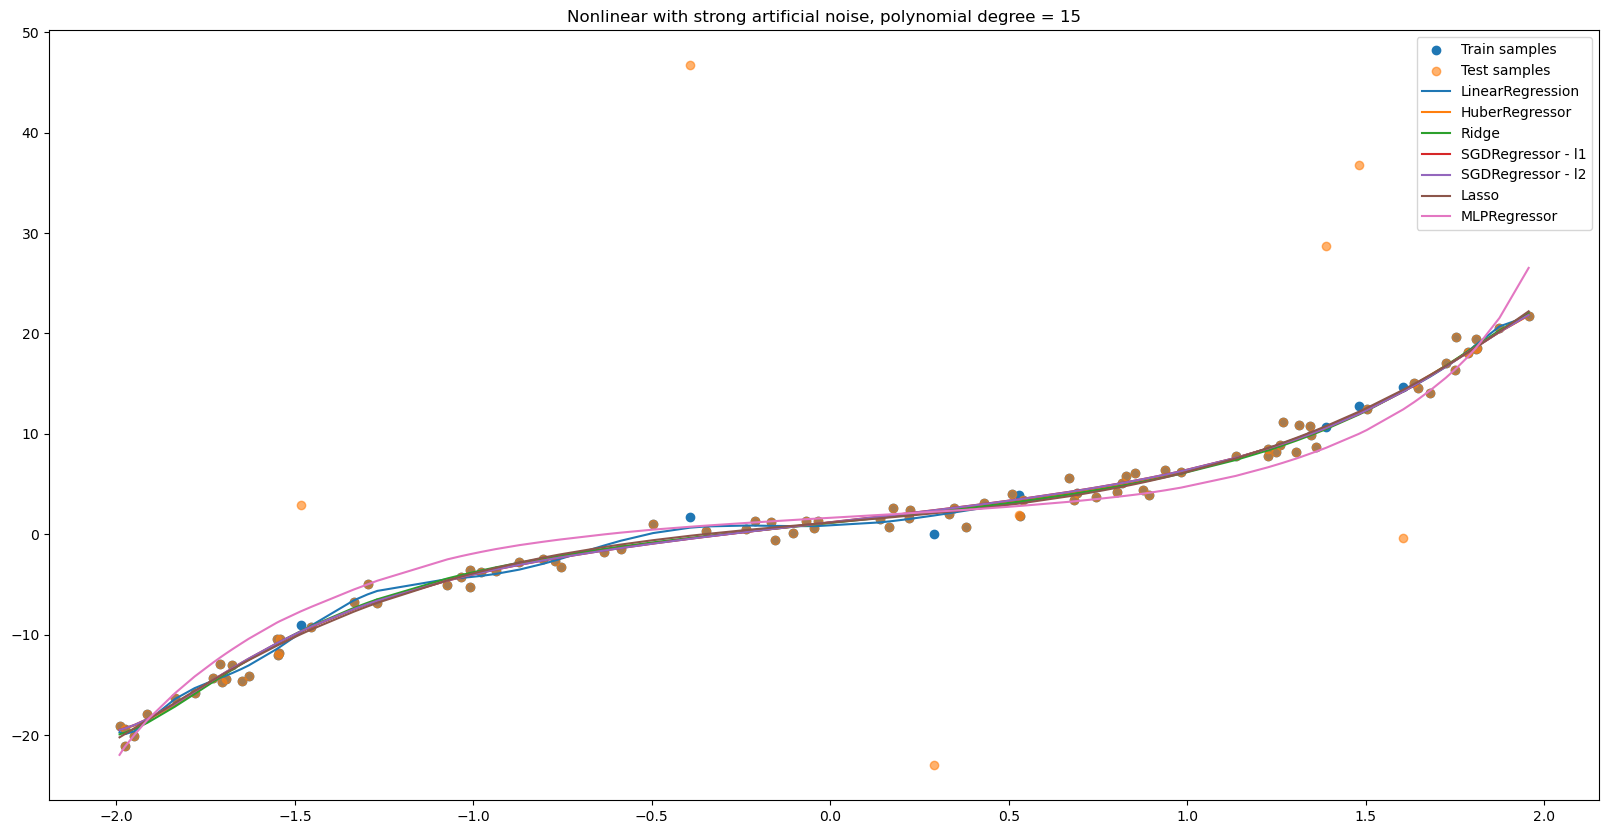

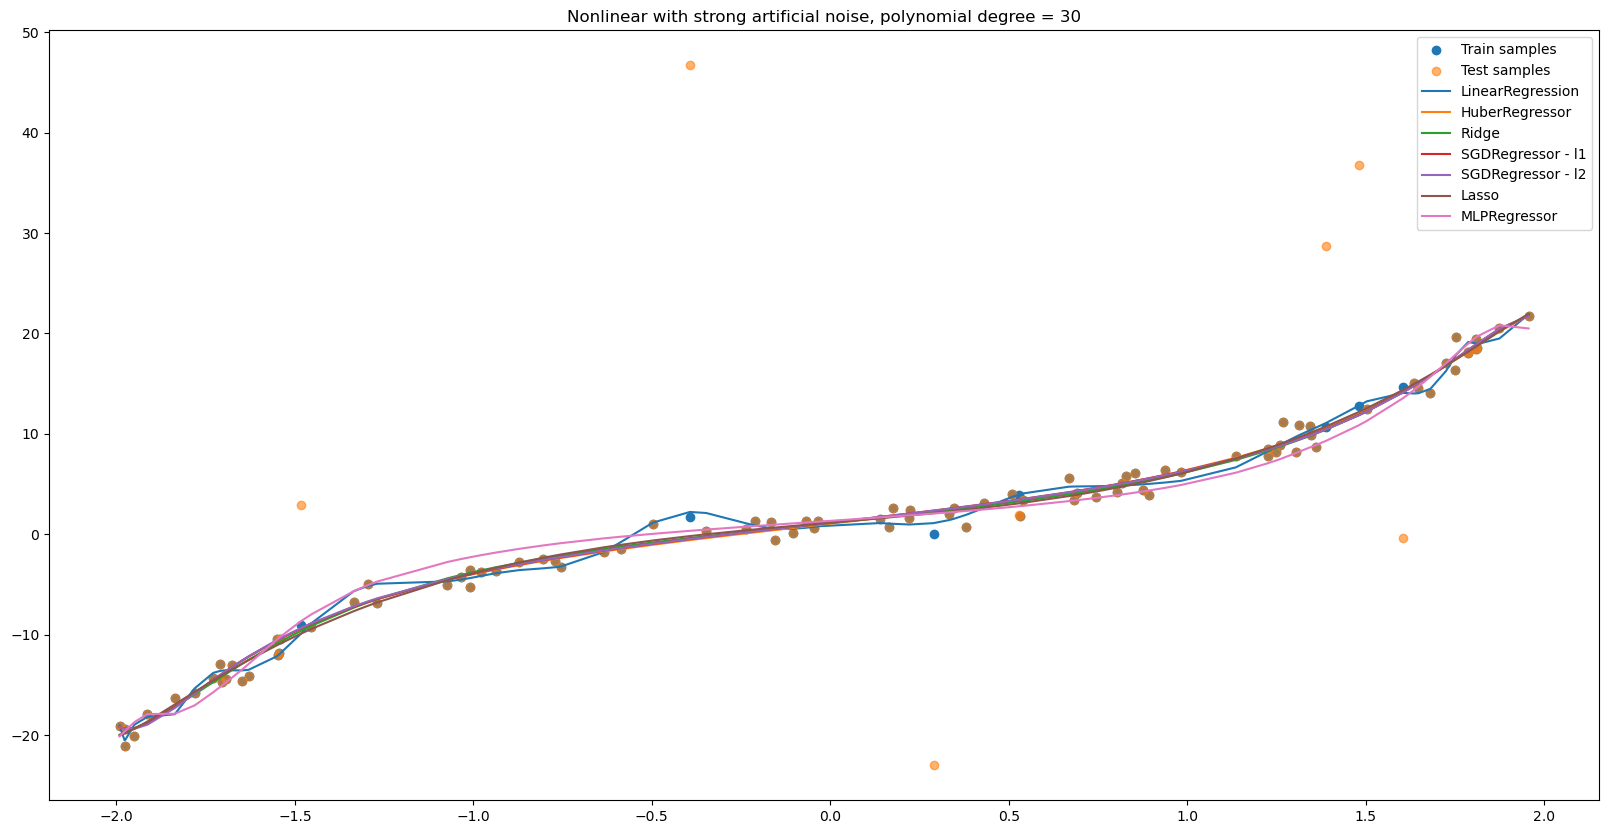

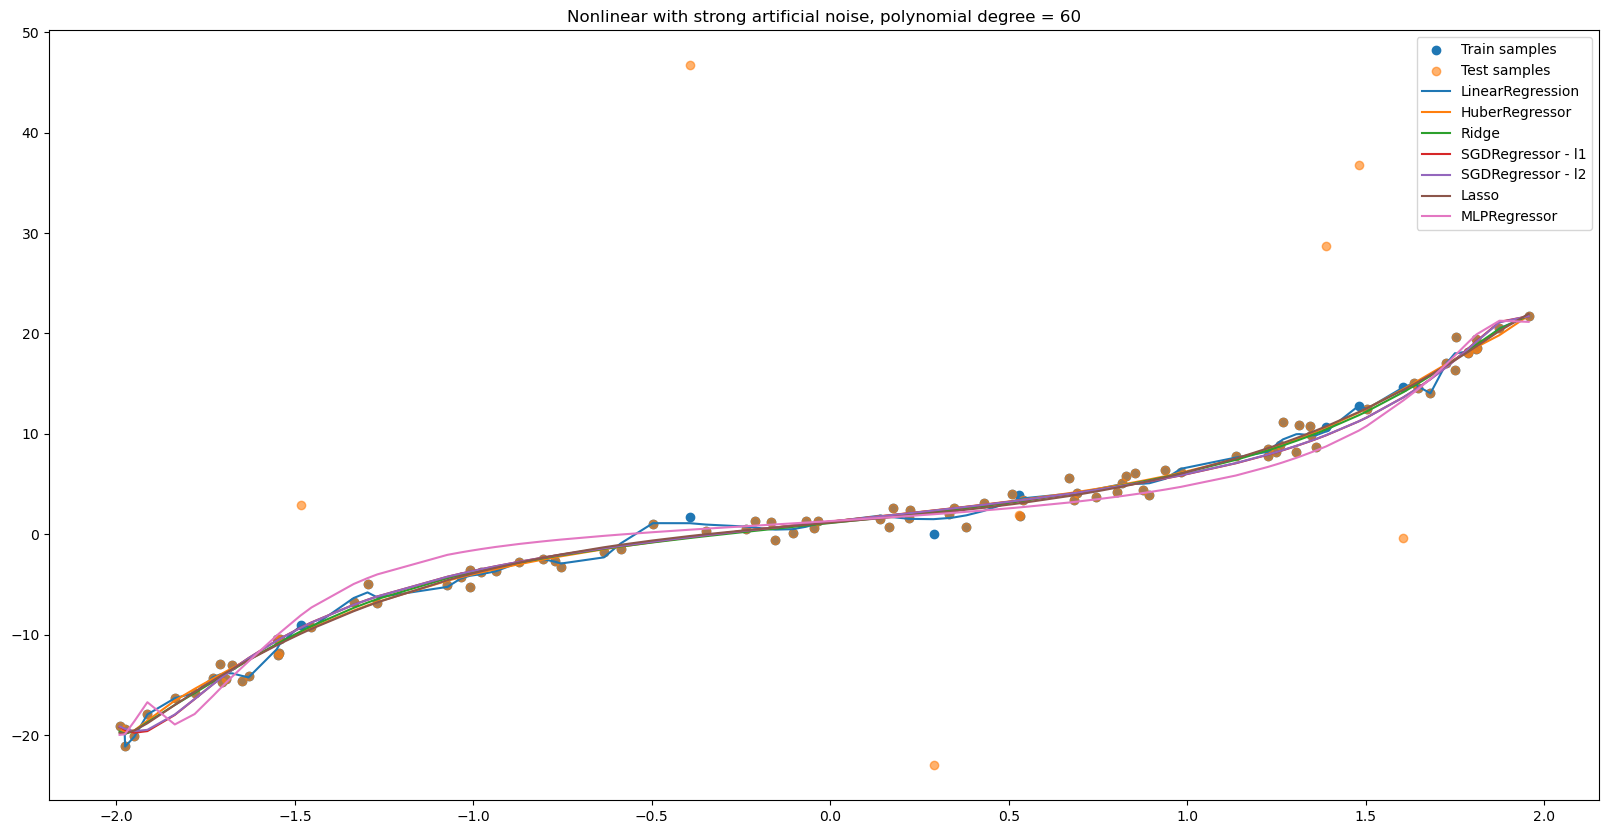

                                    fit time       mae        mse  \
polynomial degree regressor                                         
3                 HuberRegressor    0.008999  2.070939  42.089618   
                  Lasso             0.000000  2.072742  42.085416   
                  LinearRegression  0.001000  2.073349  42.085809   
                  MLPRegressor      0.094998  2.894657  45.895318   
                  Ridge             0.000000  2.074191  42.149624   
                  SGDRegressor      0.025497  2.092997  42.266828   
5                 HuberRegressor    0.035999  2.066421  42.198239   
                  Lasso             0.000000  2.072499  42.094251   
                  LinearRegression  0.000995  2.074227  42.038669   
                  MLPRegressor      0.093999  2.764594  44.512466   
                  Ridge             0.000999  2.081513  42.500379   
                  SGDRegressor      0.014998  2.091860  42.605793   
10                HuberRegressor  

In [14]:
with warnings.catch_warnings() and pd.option_context('display.max_rows', None, 'display.max_columns', None):
    regressionClassifierTest.experiment(dataset_type='nonlinear', strong_noise=True)
    aggregated = pd.pivot_table(regressionClassifierTest.results, values=['fit time', 'predict time', 'mse', 'mae'], index=['polynomial degree', 'regressor'], aggfunc=np.mean)
    print(aggregated)

###### Wnioski:
* Dla modelu liniowego bez sztucznego szumu modele poradziły sobie bardzo dobrze. Dla wszystkich z nich średnie miary MAE (0.17) oraz MSE (0.05) są niskie, a rysunek przedstawia, że są one dopasowane bardzo dobrze. Na rysunku można zauważyć delikatne odchylenie linii wizualizującej `SGDRegressor(pentaly='l1')`. 
* W modelu liniowym z dodanym sztucznym szumem wykres przedstawia dobre dopasowanie się modeli regresji do danych, jednak średnie miary MAE i MSE są już znacznie wyższe: MAE~=2.3, MSE~=67.78. Wskazywałoby to, że regresory nie poradziły sobie z dopasowaniem się do danych, jednak na wykresie przedstawione są one na dopasowane.
* W modelu nieliniowym bez sztucznego szumu najgorzej dopasował się `MLPRegressor` oraz nienajlepiej dopasował się model `LinerRegression`, który miejscami odstaje od pozostałych linii modeli oraz jest "połamany" w niektórych miejscach. Pozostałe modele dopasowały się bardzo dobrze. Na fakt złego dopasowania się `MLPRegressor` wskazują wyższe od pozostałych miary MSE ora MAE. Dla `LinearRegressor` pomimo wygięć, miary MSE i MAE są na podobnym poziomie jak dla pozostałych modeli. Wygięcia te są tym większe im bardziej są przewymiarowywane dane.
* W modelu nieliniowym z dodanym sztucznym szumem również najgorzej został dopasowany `MLPRegressor`. Także w miarę coraz bardziej przewymiarowanych danych `LinearRegressor` zaczyna być coraz bardziej powyginany, pomimo braku odstawania od pozostałych dobrze dopasowanych modeli w miarach MSE oraz MAE. Tutaj już miary te są większe niż w przypadku modelu nieliniowego bez sztucznego szumu (MSE 1 < 42, MAE 0.67 < 2.0).
* Pomimo małych zmianach w miarze MAE, wydaje się mieć ona większe znaczenie w strojeniu modelu niż MSE.